In [3]:
import pandas as pd
import numpy as np

# Load spectra and labels
X_raw = pd.read_csv("NOx_spectra.csv")
y = pd.read_csv("NOx_labels.csv")

# Drop index column if present (e.g., "Unnamed: 0")
if X_raw.columns[0].lower().startswith("unnamed") or X_raw.columns[0].lower() == "index":
    X_raw = X_raw.drop(columns=X_raw.columns[0])
if y.columns[0].lower().startswith("unnamed") or y.columns[0].lower() == "index":
    y = y.drop(columns=y.columns[0])

# Check if shapes align
assert X_raw.shape[0] == y.shape[0], "Mismatch in number of samples"


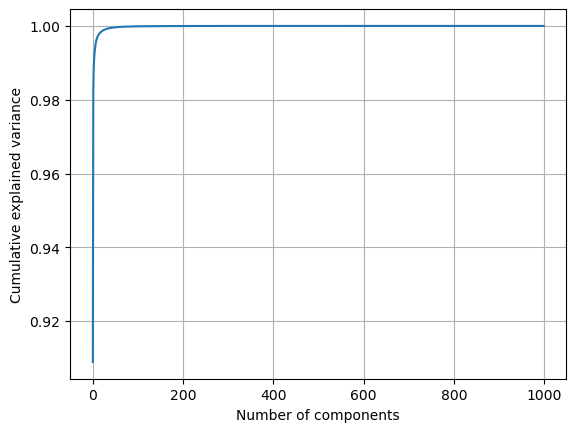

Using 2 components


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Optional: Log-transform to handle very small values
X_log = np.log10(X_raw + 1e-25)  # Avoid log(0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# PCA: first fit all to examine variance explained
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Plot explained variance
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show()

# Choose number of components that explains ~95% variance
n_components = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.95) + 1
print(f"Using {n_components} components")

# Reduce dimensionality
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.1
)


In [16]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)
model = MultiOutputRegressor(xgb)
model.fit(X_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [17]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)

for i, col in enumerate(y.columns):
    r2 = r2_score(y_test[col], y_pred[:, i])
    rmse = mean_squared_error(y_test[col], y_pred[:, i], squared=False)
    print(f"{col}: R² = {r2:.3f}, RMSE = {rmse:.2f}")


NO: R² = 0.143, RMSE = 0.06
NO2: R² = 0.414, RMSE = 0.06
N2O: R² = 0.166, RMSE = 0.06


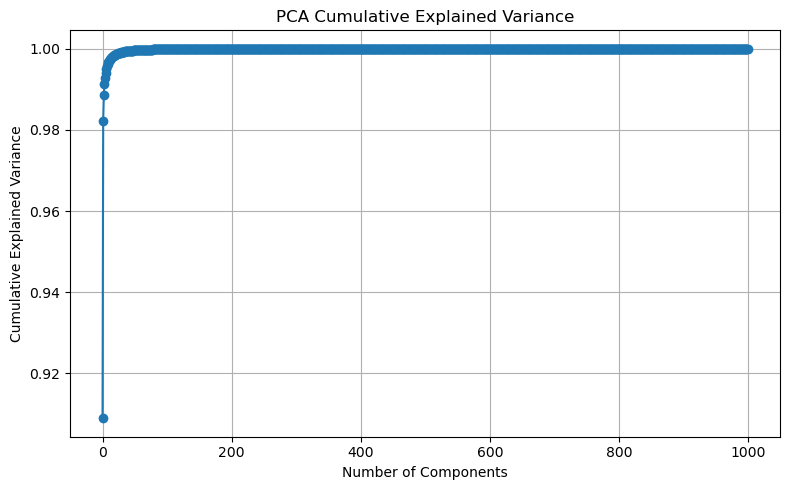

Selected 2 components for ~98% variance.

Performance Metrics:
NO: R² = 0.319, RMSE = 0.05
NO2: R² = 0.333, RMSE = 0.06
N2O: R² = 0.289, RMSE = 0.06


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# --- Load Data ---
X_raw = pd.read_csv("NOx_spectra.csv")
y = pd.read_csv("NOx_labels.csv")

# Drop index column if present
if X_raw.columns[0].lower().startswith("unnamed") or X_raw.columns[0].lower() == "index":
    X_raw = X_raw.drop(columns=X_raw.columns[0])
if y.columns[0].lower().startswith("unnamed") or y.columns[0].lower() == "index":
    y = y.drop(columns=y.columns[0])

# --- Log Transform ---
X_log = np.log10(X_raw + 1e-25)  # Small epsilon to avoid log(0)

# --- Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# --- PCA (initial) to check variance explained ---
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Select number of components to keep ~95% variance
n_components = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.95) + 1
print(f"Selected {n_components} components for ~98% variance.")

# --- Final PCA ---
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.1)

# --- Linear Regression ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predict ---
y_pred = model.predict(X_test)

# --- Evaluate ---
print("\nPerformance Metrics:")
for i, col in enumerate(y.columns):
    r2 = r2_score(y_test[col], y_pred[:, i])
    rmse = mean_squared_error(y_test[col], y_pred[:, i], squared=False)
    print(f"{col}: R² = {r2:.3f}, RMSE = {rmse:.2f}")
